<a href="https://colab.research.google.com/github/PranavDixit2/LungCancer/blob/main/Programing_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

#########################################################
## Your code here:
## Import 'compute_class_weight' from the corresponding library in sklearn
#########################################################

In [ ]:
# ---------------------------
# 1. Load and Prepare the Data
# ---------------------------
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Function to downsample selected classes in the training set
def downsample_classes(x, y, classes_to_downsample, fractions):
    """
    Downsample specified classes in the dataset using different fractions.

    Args:
        x (np.array): Input images.
        y (np.array): Integer labels.
        classes_to_downsample (list): List of class labels to downsample.
        fractions (list): List of fractions (between 0 and 1) corresponding to each class in
                          classes_to_downsample, indicating the proportion of samples to retain.

    Returns:
        x_down (np.array): Downsampled images.
        y_down (np.array): Downsampled labels.
    """
    indices = []
    # Loop over each unique class in y
    for cls in np.unique(y):
        cls_idx = np.where(y == cls)[0]
        # If this class is in the list to downsample, use the corresponding fraction
        if cls in classes_to_downsample:
            frac = fractions[classes_to_downsample.index(cls)]
            n_samples = int(len(cls_idx) * frac)
            sampled_idx = np.random.choice(cls_idx, size=n_samples, replace=False)
            indices.extend(sampled_idx)
        else:
            # Retain all samples for classes not specified for downsampling
            indices.extend(cls_idx)
    indices = np.array(indices)
    return x[indices], y[indices]

# Set random seed for reproducibility
np.random.seed(42)

# Downsample all classes using different fractions:
classes_to_downsample = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
downsample_fraction = [0.1, 0.3, 0.65, 0.58, 0.08, 0.05, 0.92, 0.98, 0.8, 0.1]
x_train_unbal, y_train_unbal = downsample_classes(x_train, y_train, classes_to_downsample, downsample_fraction)

print("Original training set size:", x_train.shape[0])
print("Unbalanced training set size:", x_train_unbal.shape[0])

# Preprocess images: reshape to (28, 28, 1) and normalize pixel values
x_train_unbal = x_train_unbal.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_proc = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding (10 classes)
y_train_unbal_cat = to_categorical(y_train_unbal, 10)
y_test_cat = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original training set size: 60000
Unbalanced training set size: 27636


<ipython-input-3-91cda9b799ce>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_orig, ax=axes[0], palette="viridis", order=order_list)
<ipython-input-3-91cda9b799ce>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_down, ax=axes[1], palette="viridis", order=order_list)


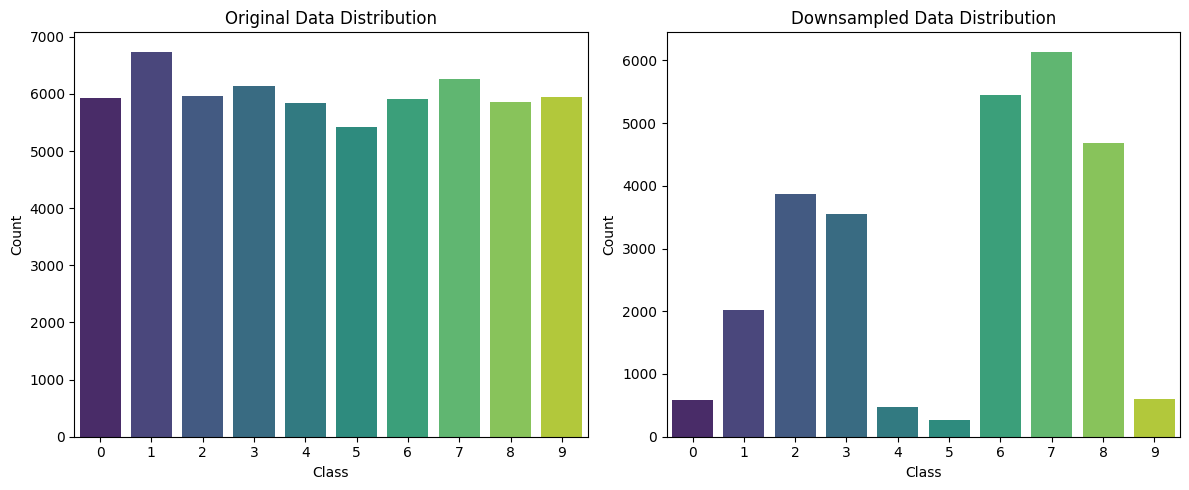

In [ ]:
def plot_label_distribution(y_original, y_downsampled, class_names=None):
    """
    Plots side-by-side bar charts of the label distributions
    for the original and downsampled datasets.

    Args:
        y_original (array-like): Array of labels from the original dataset.
        y_downsampled (array-like): Array of labels from the downsampled dataset.
        class_names (list, optional): List of class names (e.g., ['0', '1', ..., '9']).
                                      If None, numeric labels will be used.
    """
    # Ensure labels are flattened numpy arrays
    y_orig = np.array(y_original).flatten()
    y_down = np.array(y_downsampled).flatten()

    # Create DataFrames for easier plotting with seaborn
    df_orig = pd.DataFrame({'Label': y_orig})
    df_down = pd.DataFrame({'Label': y_down})

    # If class names are provided, map numeric labels to names
    if class_names is not None:
        df_orig['Label'] = df_orig['Label'].apply(lambda x: class_names[int(x)])
        df_down['Label'] = df_down['Label'].apply(lambda x: class_names[int(x)])

    # Determine the order in which to plot classes
    # If you have class_names, use them directly; otherwise, sort unique labels
    if class_names is not None:
        order_list = class_names
    else:
        order_list = sorted(df_orig['Label'].unique())

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original distribution with specified order
    sns.countplot(x='Label', data=df_orig, ax=axes[0], palette="viridis", order=order_list)
    axes[0].set_title("Original Data Distribution")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Count")

    # Plot downsampled distribution with the same order
    sns.countplot(x='Label', data=df_down, ax=axes[1], palette="viridis", order=order_list)
    axes[1].set_title("Downsampled Data Distribution")
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

class_names = [str(i) for i in range(10)]
plot_label_distribution(y_train, y_train_unbal, class_names)

In [ ]:
# ---------------------------
# 2. Build the CNN Model
# ---------------------------
# Use the same CNN architecture as the previous assignment


#########################################################
## Your code here:
## Create an input layer with shape (28, 28, 1) and give it the name: 'input_layer'
inputs = input = Input(shape=(28, 28, 1), name='input_layer')
#########################################################

x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv_layer1')(inputs)
x = MaxPooling2D(pool_size=(2, 2), name='pool_layer1')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv_layer2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_layer2')(x)
x = Flatten(name='flatten')(x)

#########################################################
## Your code here:
## Create a fully connected (also known as Dense) layer with 64 nodes, and a relu activation function and give it the name: 'dense_layer1'
x = Dense(64, activation='relu', name='dense_layer1')(x)
#########################################################

#########################################################
## Your code here:
## Create an output layer using a fully connected (also known as Dense) layer with 10 nodes, and a softmax activation function and give it the name: 'output_layer'
outputs = Dense(10, activation='softmax', name='output_layer')(x)
#########################################################

model = Model(inputs=inputs, outputs=outputs, name='mnist_cnn_classifier')
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mnist_cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer1 (Conv2D)                 │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer1 (MaxPooling2D)           │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer2 (Conv2D)                 │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer2 (MaxPooling2D)           │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer1 (Dense)                 │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------------------------
# 3. Train & Evaluate Without Class Weighting
# ---------------------------
print("\nTraining on unbalanced dataset WITHOUT class weighting...")
history_no_weight = model.fit(x_train_unbal, y_train_unbal_cat, epochs=5, batch_size=128, validation_split=0.1)


Training on unbalanced dataset WITHOUT class weighting...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.7630 - loss: 0.7896 - val_accuracy: 0.7554 - val_loss: 2.7923
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9739 - loss: 0.0855 - val_accuracy: 0.7670 - val_loss: 2.6775
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9843 - loss: 0.0492 - val_accuracy: 0.7674 - val_loss: 3.1392
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9879 - loss: 0.0394 - val_accuracy: 0.7753 - val_loss: 3.0253
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9906 - loss: 0.0330 - val_accuracy: 0.7746 - val_loss: 2.9988


In [ ]:
# Evaluate the model on test data
test_loss_no_weight, test_acc_no_weight = model.evaluate(x_test_proc, y_test_cat)
print("Test accuracy WITHOUT class weighting:", test_acc_no_weight)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8756 - loss: 1.4556
Test accuracy WITHOUT class weighting: 0.8794000148773193


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


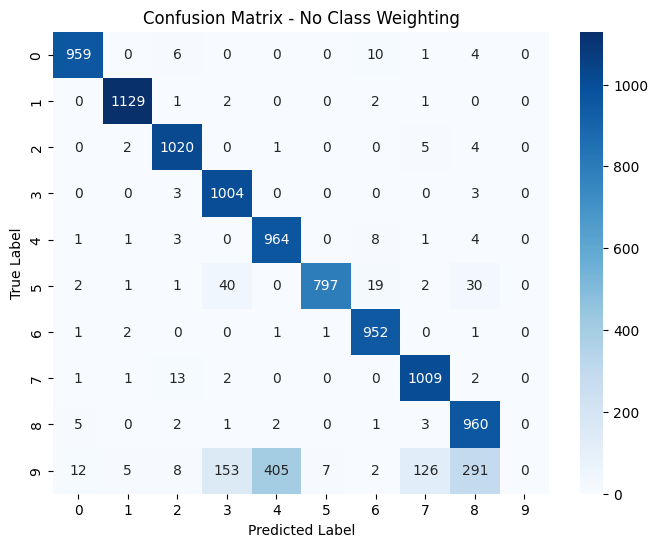

Classification Report (No Class Weighting):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.84      0.99      0.91      1010
           4       0.70      0.98      0.82       982
           5       0.99      0.89      0.94       892
           6       0.96      0.99      0.98       958
           7       0.88      0.98      0.93      1028
           8       0.74      0.99      0.84       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.88     10000
   macro avg       0.80      0.88      0.84     10000
weighted avg       0.80      0.88      0.84     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Generate predictions and compute confusion matrix and classification report
y_pred_probs_no_weight = model.predict(x_test_proc)
y_pred_no_weight = np.argmax(y_pred_probs_no_weight, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
cm_no_weight = confusion_matrix(y_true, y_pred_no_weight)

plt.figure(figsize=(8,6))
sns.heatmap(cm_no_weight, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - No Class Weighting")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("Classification Report (No Class Weighting):")
print(classification_report(y_true, y_pred_no_weight))

In [ ]:
# ---------------------------
# 4. Train & Evaluate With Class Weighting
# ---------------------------

#########################################################
## Your code here:
## Compute balanced class weights via sklearn's compute_class_weight function using the y_train_unbal labels and then turn it into a class weight dictionary:
classes = np.unique(y_train_unbal)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_unbal)
class_weight_dict = dict(zip(classes, class_weights))
#########################################################

print("Computed Class Weights:", class_weight_dict)

# For a fair comparison, reinitialize the model (or clone it)
# Here we clone the architecture and compile a new instance
model_weighted = clone_model(model)
model_weighted.set_weights(model.get_weights())  # Optionally, you could reinitialize weights instead
model_weighted.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# The class weight dictionary can be passed to the fit function as an input argument: lass_weight=class_weight_dict
print("\nTraining on unbalanced dataset WITH class weighting...")
history_weighted = model_weighted.fit(x_train_unbal, y_train_unbal_cat, epochs=5, batch_size=128, validation_split=0.1, class_weight=class_weight_dict)

Computed Class Weights: {np.uint8(0): np.float64(4.668243243243243), np.uint8(1): np.float64(1.3667655786350148), np.uint8(2): np.float64(0.7137396694214876), np.uint8(3): np.float64(0.7773839662447257), np.uint8(4): np.float64(5.917773019271949), np.uint8(5): np.float64(10.197785977859779), np.uint8(6): np.float64(0.5076414401175606), np.uint8(7): np.float64(0.4501710376282782), np.uint8(8): np.float64(0.5905128205128205), np.uint8(9): np.float64(4.652525252525253)}

Training on unbalanced dataset WITH class weighting...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9875 - loss: 0.0366 - val_accuracy: 0.7735 - val_loss: 3.8979
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9910 - loss: 0.0226 - val_accuracy: 0.7652 - val_loss: 3.7301
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9941 - loss: 0.0145 - val_accuracy: 0.7598 - val_loss: 4.2620
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9930 - loss: 0.0

In [ ]:
# Evaluate the weighted model on test data
test_loss_weighted, test_acc_weighted = model_weighted.evaluate(x_test_proc, y_test_cat)
print("Test accuracy WITH class weighting:", test_acc_weighted)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8852 - loss: 2.4040
Test accuracy WITH class weighting: 0.8877000212669373


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


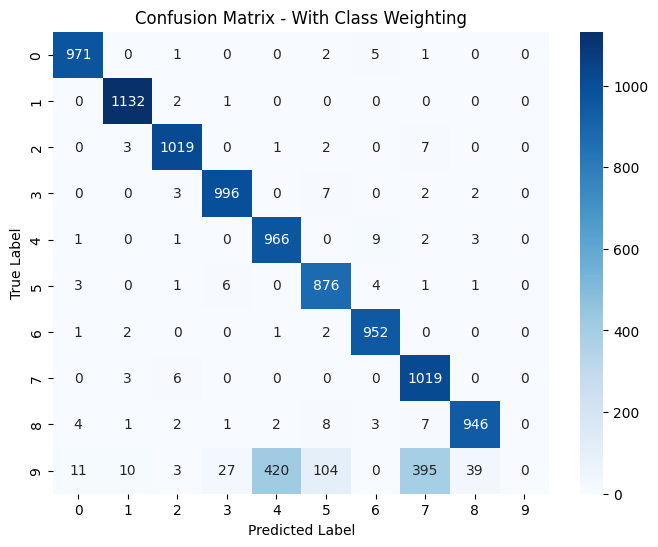

Classification Report (With Class Weighting):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.69      0.98      0.81       982
           5       0.88      0.98      0.93       892
           6       0.98      0.99      0.99       958
           7       0.71      0.99      0.83      1028
           8       0.95      0.97      0.96       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.89     10000
   macro avg       0.81      0.89      0.85     10000
weighted avg       0.81      0.89      0.85     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Generate predictions for the weighted model and compute metrics
y_pred_probs_weighted = model_weighted.predict(x_test_proc)
y_pred_weighted = np.argmax(y_pred_probs_weighted, axis=1)
cm_weighted = confusion_matrix(y_true, y_pred_weighted)

plt.figure(figsize=(8,6))
sns.heatmap(cm_weighted, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - With Class Weighting")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("Classification Report (With Class Weighting):")
print(classification_report(y_true, y_pred_weighted))

In [ ]:
# ---------------------------
# 5. Compare Results
# ---------------------------
print("\nComparison of Test Accuracies:")
print("Without Class Weighting:", "%.4f" % test_acc_no_weight)
print("With Class Weighting:", "%.4f" % test_acc_weighted)
print("\nThe absolute difference in accuracy between the two approaches is:", "%.4f" % (abs(test_acc_no_weight - test_acc_weighted)*100), "%")


Comparison of Test Accuracies:
Without Class Weighting: 0.8794
With Class Weighting: 0.8877

The absolute difference in accuracy between the two approaches is: 0.8300 %
